# ThermalShift Simulations Notebook
This notebook requires Julia 1.8.5

# Table of Contents
- [Simulations](#simulations)
- [Import](#import)
- [1. Steady State](#1-steady-state)
  - [1.1. Beam Profile for Different Powers](#11-beam-profile-for-different-powers)
  - [1.2. Influence of z₀ on the Focal Shift (Δf)](#12-influence-of-z₀-on-the-focal-shift-δf)
  - [1.3. Broadening of the Waist w₀](#13-broadening-of-the-waist-w₀)
  - [1.4. Measure of the Focal Power Density](#14-measure-of-the-focal-power-density)
- [2. Temporal Evolution](#2-temporal-evolution)
  - [2.1. Influence of z₀](#21-influence-of-z₀)
  - [2.2. Influence of Mean Power](#22-influence-of-mean-power)


![SumUp](Figure/Fig.png)

# Simulations 

## Import

In [ ]:
#using Revise
include("simulations_codes/grinlens_t.jl")
#import PyPlot
using .Grinlens_t
using Plots
using DelimitedFiles
using CSV

## 1. Steady state 

### 1.1 Beam Profile for Different Powers

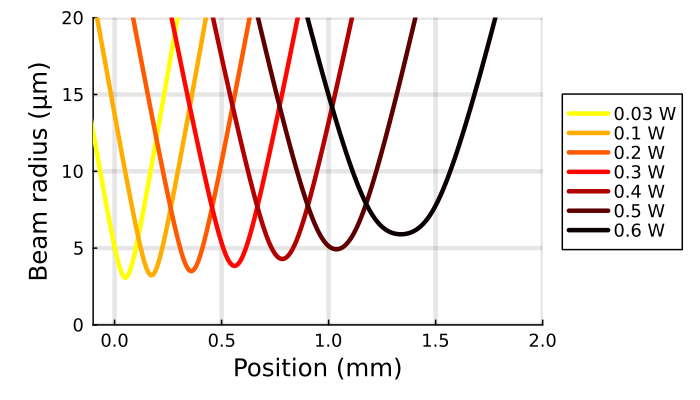

In [10]:
# Flatten power list
pows = vcat(0.03, collect(0.1:0.1:0.65))
colorstest = cgrad(:hot, length(pows)+2, categorical = true, rev= true)
# Create parameters
W0 = 3e-6
P = map(p -> Parameters(P=p, l=1e-5, steps=0:1e-5:2e-2, w0=W0,z0=0.015, n=1.33, α=19,λ = 1035e-9,t=Inf), pows) # parameter array

# Simulate beam propagation
O = propagate.(P)

# Define ROI for plotting
ROI = 1000:1577

# Initialize plot
p5 = plot(size=(700,400), gridlinewidth=3, thickness_scaling=1.5)

# Plot beam profiles
for (i, pow) in enumerate(pows)
    plot!(
        p5,
        (P[i].steps .- P[i].z0) .* 1e3,      # x: mm
        O[i].wonlens .* 1e6,                 # y: µm
        lw=3,
        label = "$(pow) W",
        legend=:outerright,
        color = colorstest[i+2]
    )
end

# Compute focal shift positions and scatter them
#minwidthpos = map((o, p) -> o.minwidthpos - p.z0, O, P) .* 1e3  # in mm
#scatter!(p5, minwidthpos, zeros(length(minwidthpos)), markercolor=:black, label="")

xlabel!(p5, "Position (mm)")
ylabel!(p5, "Beam radius (µm)")
ylims!(p5, (0, 20))
xlims!(p5, (-.1,2))
display(p5)

### 1.2 Influence of $z_0$ on the focal shift ($\Delta f$)

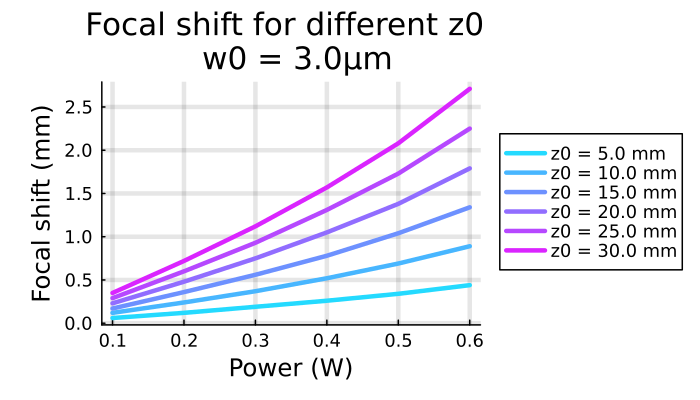

In [9]:
#Figure2
P = map(p -> Parameters(P=p, l=1e-6, steps=0:1e-5:2e-2, w0=3.6e-6, n=1.33, t=Inf), pows) # parameter array

pows = 0.1:0.1:0.6
z0s = 0.005:0.005:0.030 # z0 (m): distance of beam waist without focal shift to chamber entry

colorstest = cgrad(:hot, length(z0s)+2, categorical = true, rev= true)
colorstest = cgrad(:cool, length(z0s)+2, categorical = true, rev= true)
minwidthpos_z0 = zeros(length(pows),length(z0s))
for (i,Z0) in enumerate(z0s)
    #println(Z0)
    P = map(p -> Parameters(P=p, l=1e-5, w0=3e-6, n=1.33, α=19,λ = 1035e-9,z0 = Z0, t=Inf), pows) # parameter array
    p = P[1]
    O = propagate.(P) # observables for these parameters
    minwidthpos = map(o->o.minwidthpos-P[1].z0, O).*1e3
    minwidthpos_z0[:,i] = minwidthpos
end

p3 = plot(size=(700,400), gridlinewidth=3, thickness_scaling=1.5, legend=:outerright) #legend=:bottomright
for (i,z0) in enumerate(z0s)
    plot!(pows,minwidthpos_z0[:,i],lw=3,label ="z0 = "* string(z0*1e3) * " mm", color = colorstest[length(z0s)-i+2])
end

title!("Focal shift for different z0 \n w0 = " * string(P[1].w0*1000000) * "μm")
xlabel!("Power (W)")
ylabel!("Focal shift (mm)")
#ylims!((0.01,0.4))


display(p3)


#savefig("Figures/2025_Fig01.pdf")


### 1.3 Broadening of the waist $w_0$

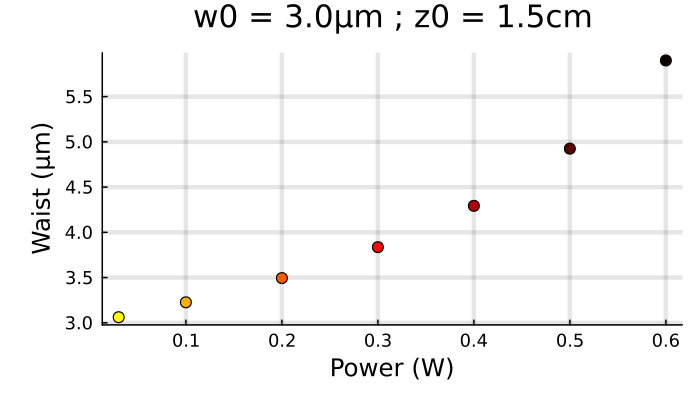

In [16]:
# Flatten power list
pows = vcat(0.03, collect(0.1:0.1:0.65))
colorstest = cgrad(:hot, length(pows)+2, categorical = true, rev= true)
Z0 = 0.015 # z0 (m): distance of beam waist without focal shift to chamber entry# Create parameters
W0 = 3e-6
P = map(p -> Parameters(P=p, l=1e-5, steps=0:1e-5:2e-2, w0=W0,z0=0.015, n=1.33, α=19,λ = 1035e-9,t=Inf), pows) # parameter array
O = propagate.(P) # observables for these parameters
minwidth = map(o->o.minwidth, O).*1e6 # μm

# setup plot
p5 = plot(size=(700,400), gridlinewidth=3, thickness_scaling=1.5)


for (ii,pow) in enumerate(pows)
    plot!(([pow],minwidth[ii]), seriestype=:scatter, label="",color = colorstest[ii+2])
end
#plot!(pows, minwidth , lw=3,label = "w0(P)",legend=:outerright, color="black", alpha=0.5) # mm / µm        #plot!((p.steps[ROI].-p.z0).*1e3, -o.wonlens[ROI].*1e6, lw=3, legend=false)#ff8019a2") # mm / µm

# plot waist position

title!("Beam profile")
xlabel!("Power (W)")
ylabel!("Waist (µm)")
title!("w0 = " * string(P[1].w0 * 1000000) * "μm ; z0 = " * string(P[1].z0*100) * "cm")
#ylims!((0,40))
#xlims!((0,2))
display(p5)
#savefig("Figures/2025_Fig06.pdf")


# plot waist position

### 1.4 Measure of the Focal Power Density

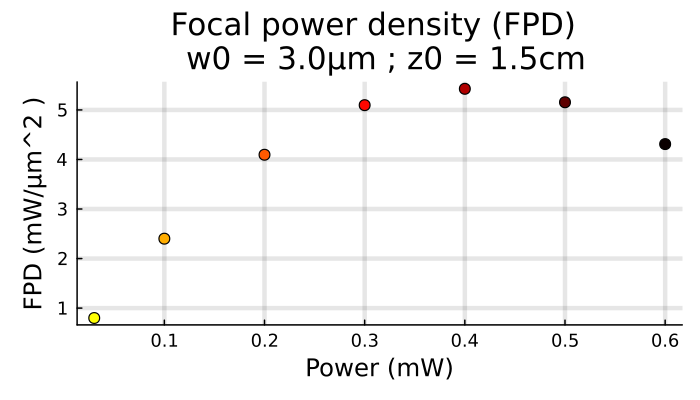

In [17]:
pows = vcat(0.03, collect(0.1:0.1:0.65)) # high resolution (hR) power range for computation
P = map(p -> Parameters(P=p, l=1e-5, w0=3e-6, n=1.33, z0=1.5e-2, α=19,λ = 1035e-9), pows)
O = propagate.(P)

minfullwidth = map(o->2*o.minwidth, O).*1e3 # mm
 #   minfullwidth_z0[:,i] = map(o->2*o.minwidth, O).*1e3 # mm
 #   FPD_z0[:,i] = (pows_hR*1000)./(minfullwidth_z0[:,i]*1000).^2 # mW/μm^2
p9 = plot(size=(700,400), gridlinewidth=3, thickness_scaling=1.5)

colorstest = cgrad(:hot, length(pows)+2, categorical = true, rev= true)
for (ii,pow) in enumerate(pows)
    plot!(([pow],(pow*1000)./(minfullwidth[ii]*1000).^2), seriestype=:scatter, label="", color = colorstest[ii+2])
end
#plot!(pows, (pows*1000)./(minfullwidth*1000).^2, lw=3, legend=false, color = "black", alpha = 0.5,
#    xlabel="Power (W)", ylabel = "FPD (mW/μm²)",left_margin = 5Plots.mm, right_margin = 15Plots.mm) # numerical model


title!("Focal power density (FPD) \n w0 = " * string(P[1].w0*1000000) * "μm ; z0 = " * string(P[1].z0*100) * "cm")

ylabel!("FPD (mW/μm^2 )")
xlabel!("Power (mW)")
display(p9)
#savefig("Figures/2025_Fig07.pdf")

## 2. Temporal evolution 

### 2.1 Influence of $z_0$

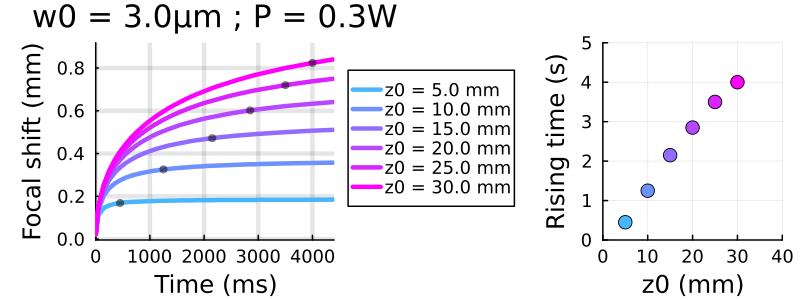

In [20]:
time_ = [0.001; 0.05:0.1:3;3:0.5:6] # simulation time steps (s)
#z0s = 0.002:0.001:0.015 # z0 (m): distance of beam waist without focal shift to chamber entry
z0s = 0.005:0.005:0.030
pow = 0.3 # laser power (W)
a = 0.90 # fraction of focal shift to reach
c = zeros(Int,length(z0s))
minwidthpos_z0 = zeros(length(time_),length(z0s))
minwidthpos_t = zeros(length(time_),length(z0s))
show_plot = 0
colorstest = cgrad(:cool, length(z0s)+2, categorical = true, rev= true)
for (i,Z0) in enumerate(z0s)
    P = map(x -> Parameters(P=pow, l=1e-6, w0=3e-6, n=1.33, z0 = Z0, t=x,λ = 1035e-9, α=19), time_) # parameter array
    p = P[1]
    O = propagate.(P) # observables for these parameters
    minwidthpos = map(o->o.minwidthpos-p.z0, O).*1e3 # mm
    minwidthpos_z0[:,i] = minwidthpos
end

# === Plot focal shift over time for different zo. NOTE: We plot only the first 9 values
p3 = plot(size=(700,400), gridlinewidth=3, thickness_scaling=1.5, legend=:outerright) #legend=:bottomright

for (i,z0) in enumerate(z0s)
    plot!(time_*1e3,minwidthpos_z0[:,i],lw=3,label ="z0 = "* string(z0*1e3) * " mm", color = colorstest[5-i+2])
end



for (i,z0) in enumerate(z0s)
    y = minwidthpos_z0[:,i]/minwidthpos_z0[end,i]
    c[i] = Int(findfirst(x -> x > a,y))
    plot!((time_[c[i]]*1e3,minwidthpos_z0[c[i],i]), seriestype=:scatter, markersize=3, markerstrokealpha=0.5, legend =:outerright, label="", color="black",alpha=0.5)
end

title!("w0 = " * string(P[1].w0*1000000) * "μm ; P = " * string(pow) * "W")
xlabel!("Time (ms)")
ylabel!("Focal shift (mm)")

xlims!((0,4400))

# Prepare right subplot
# Prepare right subplot (e.g., rising time vs z₀)
p2 = plot()

for (i, z0) in enumerate(z0s)
    if !isnothing(c[i])  # avoid indexing with `nothing`
        scatter!(p2,
            [z0 * 1e3],                    # x-axis in mm
            [time_[c[i]]],           # y-axis in ms
            markersize = 5,
            color = colorstest[5 - i + 2],
            alpha = 1,
            label = "")
    else
        @warn "No valid crossing index for z₀ = $(z0)"
    end
end
ylims!(p2, 0, 5)
xlims!(p2, 0, 40)
xlabel!(p2, "z0 (mm)")
ylabel!(p2, "Rising time (s)")

my_layout = @layout [a{0.7w} b{0.3w}]
# Combine into subplot layout
display(plot(p3, p2, layout =  my_layout, size = (800, 300)))
#display(p3)


### 2.2 Influence of mean power

10.0320.130.240.350.460.570.6

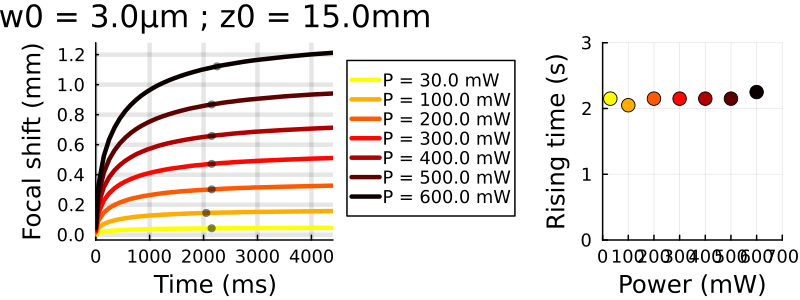

In [21]:
time_ = [0.001; 0.05:0.1:3;3:0.5:6] # simulation time steps (s)
#z0s = 0.002:0.001:0.015 # z0 (m): distance of beam waist without focal shift to chamber entry
z0s = 0.005:0.005:0.030
pow = 0.4 # laser power (W)
pows = [0.03;0.1:0.1:0.6]
Z0 = 0.015
a = 0.90 # fraction of focal shift to reach
c = zeros(Int,length(pows))
minwidthpos_pow = zeros(length(time_),length(pows))
minwidthpos_t = zeros(length(time_),length(pows))
show_plot = 0
colorstest = cgrad(:hot, length(pows)+2, categorical = true, rev= true)
for (i,pow) in enumerate(pows)
    #println(Z0)
    P = map(x -> Parameters(P=pow, l=1e-6, w0=3e-6, n=1.33, z0 = Z0, t=x,λ = 1035e-9, α=19), time_) # parameter array
    p = P[1]
    O = propagate.(P) # observables for these parameters
    minwidthpos = map(o->o.minwidthpos-p.z0, O).*1e3 # mm
    minwidthpos_pow[:,i] = minwidthpos
end

# === Plot focal shift over time for different zo. NOTE: We plot only the first 9 values
p3 = plot(size=(700,400), gridlinewidth=3, thickness_scaling=1.5, legend=:outerright) #legend=:bottomright

for (i,pow) in enumerate(pows)
    plot!(time_*1e3,minwidthpos_pow[:,i],lw=3,label ="P = "* string(pow*1e3) * " mW", color = colorstest[i+2])
end


for (i,pow) in enumerate(pows)
    y = minwidthpos_pow[:,i]/minwidthpos_pow[end,i]
    c[i] = Int(findfirst(x -> x > a,y))
    print(i,pow)
    plot!((time_[c[i]]*1e3,minwidthpos_pow[c[i],i]), seriestype=:scatter, markersize=3, markerstrokealpha=0.5, legend =:outerright, label="", color="black",alpha=0.5)
end
title!("w0 = " * string(P[1].w0*1000000) * "μm ; z0 = " * string(Z0*1e3) * "mm")
xlabel!("Time (ms)")
ylabel!("Focal shift (mm)")
#ylims!((0,0.8))
xlims!((0,4400))

# Prepare right subplot
p2 = plot()
for (i, pow) in enumerate(pows)
    scatter!(p2, ([pow*1e3], time_[c[i]]),
             markersize = 5,
             color = colorstest[i + 2],
             alpha = 1,
             label = "")
end

ylims!(p2, 0, 3)
xlims!(p2, 0, 0.7*1e3)
xlabel!(p2, "Power (mW)")
ylabel!(p2, "Rising time (s)")

my_layout = @layout [a{0.7w} b{0.3w}]
# Combine into subplot layout
display(plot(p3, p2, layout =  my_layout, size = (800, 300)))
#display()
#display(p3)
